# FB Prophet Model - Unemployment Rate (%)

Training (1997-2020), Training (2021-2023)

# Packages & Data Loading

## Packages

In [1]:
# Import packages
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from io import StringIO
import requests
import matplotlib.pyplot as plt

from prophet.plot import plot_plotly, plot_components_plotly
import plotly.graph_objects as go
import plotly.io as pio

## Data Loading

In [2]:
# Load data from Google Drive
file_id = '117pk3NKZPfYmHQyP452HeMV7_8Jq6_W0'

# Create the download URL
download_url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Use requests to get file content
response = requests.get(download_url)
response.raise_for_status()  # Ensure no error occurred

# Load the CSV directly into a DataFrame
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data)

In [3]:
# Prepare and process data
df_selected = df[['ref_date', 'value_unemployment']].copy()
df_grouped = df_selected.groupby('ref_date').agg(
    median_unemployment=('value_unemployment', 'median')
).reset_index()
df_grouped['ref_date'] = pd.to_datetime(df_grouped['ref_date'])
df_grouped.set_index('ref_date', inplace=True)

# FB Prophet Model

## Assign Training & Testing Sets

In [4]:
# Split into training and testing sets
train_data = df_grouped['1997-01-01':'2020-12-01']
test_data = df_grouped['2021-01-01':'2023-12-01']
train_data = train_data.reset_index().rename(columns={'ref_date': 'ds', 'median_unemployment': 'y'})
test_data = test_data.reset_index().rename(columns={'ref_date': 'ds', 'median_unemployment': 'y'})


# Cross Validation

In [5]:
# Optuna optimization
def optimize_prophet(trial):
    # Define hyperparameters
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 10.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Initialize model with suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model.fit(train_data)

    # Perform cross-validation
    df_cv = cross_validation(model, initial='7300 days', period='365 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    return df_p['rmse'].mean()

# Model Parameters

In [6]:
# Optimize using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(optimize_prophet, n_trials=50)

# Best parameters
best_params = study.best_params
print("\n\nBest Parameters:", best_params)

# Train model with optimized parameters
optimized_model = Prophet(**best_params)
optimized_model.fit(train_data)

[I 2024-11-30 20:31:02,590] A new study created in memory with name: no-name-814504ed-cceb-414a-aaf3-754963309765
20:31:02 - cmdstanpy - INFO - Chain [1] start processing
20:31:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:03,667] Trial 0 finished with value: 2.8773898601452244 and parameters: {'changepoint_prior_scale': 0.0033220681138914133, 'seasonality_prior_scale': 1.910826652181679, 'holidays_prior_scale': 0.110503539006403, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 2.8773898601452244.
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing
20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing
20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:04,541] Trial 1 finished with value: 2.8703748342728264 and parameters: {'changepoint_prior_scale': 0.009526736394103492, 'seasonality_prior_scale': 0.38449387912284516, 'holidays_prior_scale': 0.12169377057002566, 'seasonality_mode': 'multiplicative'}. Best is trial 1 with value: 2.8703748342728264.
20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:05,383] Trial 2 finished with value: 2.8484632329650226 and parameters: {'changepoint_prior_scale': 0.05298555864752009, 'seasonality_prior_scale': 2.374424150246401, 'holidays_prior_scale': 5.528030767003156, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 2.8484632329650226.
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:06,205] Trial 3 finished with value: 2.8819204095436137 and parameters: {'changepoint_prior_scale': 0.009715607307155587, 'seasonality_prior_scale': 0.27940324460131827, 'holidays_prior_scale': 0.24335011566443138, 'seasonality_mode': 'additive'}. Best is trial 2 with value: 2.8484632329650226.
20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:07,054] Trial 4 finished with value: 2.8403802580998985 and parameters: {'changepoint_prior_scale': 0.05335239666203363, 'seasonality_prior_scale': 0.031606024037427176, 'holidays_prior_scale': 0.038095691963608944, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstanpy - INFO - Chain [1] done processing
20:31:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstan

  0%|          | 0/3 [00:00<?, ?it/s]

20:31:07 - cmdstanpy - INFO - Chain [1] start processing
20:31:07 - cmdstanpy - INFO - Chain [1] done processing
20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing
20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:08,441] Trial 5 finished with value: 2.910875275123693 and parameters: {'changepoint_prior_scale': 0.0025573371152960095, 'seasonality_prior_scale': 0.48607625029227236, 'holidays_prior_scale': 0.071270405430162, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing
20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:09,263] Trial 6 finished with value: 2.9020795581377157 and parameters: {'changepoint_prior_scale': 0.0043323099043706004, 'seasonality_prior_scale': 0.24069124356472613, 'holidays_prior_scale': 4.971360441150123, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:10,089] Trial 7 finished with value: 2.851868445268316 and parameters: {'changepoint_prior_scale': 0.02483631250565318, 'seasonality_prior_scale': 0.013017735623858311, 'holidays_prior_scale': 0.04168050208425881, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:10,980] Trial 8 finished with value: 2.975632981149013 and parameters: {'changepoint_prior_scale': 0.29976036375099996, 'seasonality_prior_scale': 0.16397292409575082, 'holidays_prior_scale': 0.2735789513854362, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing
20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing
20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:11,848] Trial 9 finished with value: 2.8704703707808545 and parameters: {'changepoint_prior_scale': 0.17358495478904581, 'seasonality_prior_scale': 0.0234976692179021, 'holidays_prior_scale': 0.27378514446886376, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:11 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing
20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing
20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:12,710] Trial 10 finished with value: 2.857756681317807 and parameters: {'changepoint_prior_scale': 0.08205722800637127, 'seasonality_prior_scale': 0.06304398178212031, 'holidays_prior_scale': 0.011150752844546915, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:12 - cmdstanpy - INFO - Chain [1] start processing
20:31:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing
20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing
20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:13,553] Trial 11 finished with value: 2.8712106392581593 and parameters: {'changepoint_prior_scale': 0.05407456603537223, 'seasonality_prior_scale': 7.177803695483063, 'holidays_prior_scale': 2.504768957665845, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:13 - cmdstanpy - INFO - Chain [1] start processing
20:31:13 - cmdstanpy - INFO - Chain [1] done processing
20:31:14 - cmdstanpy - INFO - Chain [1] start processing
20:31:14 - cmdstanpy - INFO - Chain [1] done processing
20:31:14 - cmdstanpy - INFO - Chain [1] start processing
20:31:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:14,384] Trial 12 finished with value: 2.8457456495455924 and parameters: {'changepoint_prior_scale': 0.04499147069599957, 'seasonality_prior_scale': 1.908260299476651, 'holidays_prior_scale': 1.0873157943761558, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:14 - cmdstanpy - INFO - Chain [1] start processing
20:31:14 - cmdstanpy - INFO - Chain [1] done processing
20:31:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:31:14 - cmdstanpy - INFO - Chain [1] start processing
20:31:14 - cmdst

  0%|          | 0/3 [00:00<?, ?it/s]

20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:15,971] Trial 13 finished with value: 4.033206913087666 and parameters: {'changepoint_prior_scale': 0.0010289638660135598, 'seasonality_prior_scale': 1.240440821339277, 'holidays_prior_scale': 1.158427027780936, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy -

  0%|          | 0/3 [00:00<?, ?it/s]

20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing
20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing
20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:16,815] Trial 14 finished with value: 2.862687418221275 and parameters: {'changepoint_prior_scale': 0.020573105172746176, 'seasonality_prior_scale': 0.06406175934763567, 'holidays_prior_scale': 1.1515253085915833, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:16 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing
20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing
20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:17,774] Trial 15 finished with value: 3.004885215606566 and parameters: {'changepoint_prior_scale': 0.49198544210540923, 'seasonality_prior_scale': 6.1813002069925735, 'holidays_prior_scale': 0.020437525681566374, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:17 - cmdstanpy - INFO - Chain [1] start processing
20:31:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:18 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing
20:31:18 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing
20:31:18 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:18,633] Trial 16 finished with value: 2.896708294946234 and parameters: {'changepoint_prior_scale': 0.12941080769601473, 'seasonality_prior_scale': 0.8280887785595366, 'holidays_prior_scale': 0.7798148763912545, 'seasonality_mode': 'multiplicative'}. Best is trial 4 with value: 2.8403802580998985.
20:31:18 - cmdstanpy - INFO - Chain [1] start processing
20:31:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:18 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:19,448] Trial 17 finished with value: 2.8779722400624714 and parameters: {'changepoint_prior_scale': 0.023901009595262587, 'seasonality_prior_scale': 0.07096480483818726, 'holidays_prior_scale': 0.5689492259229875, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:19 - cmdstanpy - INFO - Chain [1] start processing
20:31:19 - cmdstanpy - INFO - Chain [1] done processing
20:31:20 - cmdstanpy - INFO - Chain [1] start processing
20:31:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:20,262] Trial 18 finished with value: 2.857650514546304 and parameters: {'changepoint_prior_scale': 0.04306105199035319, 'seasonality_prior_scale': 3.0355287133249043, 'holidays_prior_scale': 2.7854466748736524, 'seasonality_mode': 'additive'}. Best is trial 4 with value: 2.8403802580998985.
20:31:20 - cmdstanpy - INFO - Chain [1] start processing
20:31:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:20 - cmdstanpy - INFO - Chain [1] start processing
20:31:20 - cmdstanpy - INFO - Chain [1] done processing
20:31:20 - cmdstanpy - INFO - Chain [1] start processing
20:31:20 - cmdstanpy - INFO - Chain [1] done processing
20:31:20 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:21,139] Trial 19 finished with value: 2.826758857985028 and parameters: {'changepoint_prior_scale': 0.11849551459449825, 'seasonality_prior_scale': 0.01009408480477084, 'holidays_prior_scale': 0.03034514396022723, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:22,017] Trial 20 finished with value: 2.85986660347463 and parameters: {'changepoint_prior_scale': 0.15516089410038467, 'seasonality_prior_scale': 0.010220805759368477, 'holidays_prior_scale': 0.030523842651705147, 'seasonality_mode': 'additive'}. Best is trial 19 with value: 2.826758857985028.
20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:22 - cmdstanpy - INFO - Chain [1] done processing
20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:22 - cmdstanpy - INFO - Chain [1] done processing
20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:22,863] Trial 21 finished with value: 2.831161681942974 and parameters: {'changepoint_prior_scale': 0.07071154690789683, 'seasonality_prior_scale': 0.033710256345883, 'holidays_prior_scale': 0.013127760766095847, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:22 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing
20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing
20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:23,695] Trial 22 finished with value: 2.8408527518255497 and parameters: {'changepoint_prior_scale': 0.0919809453900589, 'seasonality_prior_scale': 0.026572611430958914, 'holidays_prior_scale': 0.012582322840661268, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:23 - cmdstanpy - INFO - Chain [1] start processing
20:31:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing
20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing
20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:24,582] Trial 23 finished with value: 2.937505675973274 and parameters: {'changepoint_prior_scale': 0.24840392000922407, 'seasonality_prior_scale': 0.02249378912412941, 'holidays_prior_scale': 0.04776995270357759, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:24 - cmdstanpy - INFO - Chain [1] start processing
20:31:24 - cmdstanpy - INFO - Chain [1] done processing
20:31:25 - cmdstanpy - INFO - Chain [1] start processing
20:31:25 - cmdstanpy - INFO - Chain [1] done processing
20:31:25 - cmdstanpy - INFO - Chain [1] start processing
20:31:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:25,423] Trial 24 finished with value: 2.849332227166069 and parameters: {'changepoint_prior_scale': 0.09910019790223808, 'seasonality_prior_scale': 0.03981097145025857, 'holidays_prior_scale': 0.021121027524596454, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:25 - cmdstanpy - INFO - Chain [1] start processing
20:31:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:25 - cmdstanpy - INFO - Chain [1] start processing
20:31:25 - cmdstanpy - INFO - Chain [1] done processing
20:31:25 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing
20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:26,275] Trial 25 finished with value: 2.8580905227793534 and parameters: {'changepoint_prior_scale': 0.03153670400078957, 'seasonality_prior_scale': 0.14952210506751762, 'holidays_prior_scale': 0.020623944840623333, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing
20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:26 - cmdstanpy - INFO - Chain [1] done processing
20:31:26 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:27,092] Trial 26 finished with value: 2.847406096111197 and parameters: {'changepoint_prior_scale': 0.014681812330337963, 'seasonality_prior_scale': 0.01563925125601082, 'holidays_prior_scale': 0.08349908048471474, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:27,920] Trial 27 finished with value: 2.8334539858480596 and parameters: {'changepoint_prior_scale': 0.0763299602639797, 'seasonality_prior_scale': 0.03966840095349271, 'holidays_prior_scale': 0.049313931012671564, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:28 - cmdstanpy - INFO - Chain [1] start processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:28 - cmdstanpy - INFO - Chain [1] start processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing
20:31:28 - cmdstanpy - INFO - Chain [1] start processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing
20:31:28 - cmdstanpy - INFO - Chain [1] start processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:28,785] Trial 28 finished with value: 2.9633988985689728 and parameters: {'changepoint_prior_scale': 0.24142600106924017, 'seasonality_prior_scale': 0.10618903669037921, 'holidays_prior_scale': 0.14945316289937335, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:28 - cmdstanpy - INFO - Chain [1] start processing
20:31:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:29 - cmdstanpy - INFO - Chain [1] start processing
20:31:29 - cmdstanpy - INFO - Chain [1] done processing
20:31:29 - cmdstanpy - INFO - Chain [1] start processing
20:31:29 - cmdstanpy - INFO - Chain [1] done processing
20:31:29 - cmdstanpy - INFO - Chain [1] start processing
20:31:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:29,742] Trial 29 finished with value: 2.978320172502761 and parameters: {'changepoint_prior_scale': 0.43778782716958514, 'seasonality_prior_scale': 0.047542039879964935, 'holidays_prior_scale': 0.010088861370504042, 'seasonality_mode': 'multiplicative'}. Best is trial 19 with value: 2.826758857985028.
20:31:29 - cmdstanpy - INFO - Chain [1] start processing
20:31:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:30 - cmdstanpy - INFO - Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing
20:31:30 - cmdstanpy - INFO - Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing
20:31:30 - cmdstanpy - INFO - Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:30,567] Trial 30 finished with value: 2.820446282768562 and parameters: {'changepoint_prior_scale': 0.07495043346513901, 'seasonality_prior_scale': 0.017553523625923217, 'holidays_prior_scale': 0.06813201188010767, 'seasonality_mode': 'multiplicative'}. Best is trial 30 with value: 2.820446282768562.
20:31:30 - cmdstanpy - INFO - Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:30 - cmdstanpy - INFO - Chain [1] start processing
20:31:30 - cmdstanpy - INFO - Chain [1] done processing
20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing
20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:31,438] Trial 31 finished with value: 2.827632290627462 and parameters: {'changepoint_prior_scale': 0.09178641164756193, 'seasonality_prior_scale': 0.015664298707646396, 'holidays_prior_scale': 0.0623053808612837, 'seasonality_mode': 'multiplicative'}. Best is trial 30 with value: 2.820446282768562.
20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing
20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing
20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:32,261] Trial 32 finished with value: 2.846777819702034 and parameters: {'changepoint_prior_scale': 0.12120048064284045, 'seasonality_prior_scale': 0.017101123102262607, 'holidays_prior_scale': 0.16596164195091645, 'seasonality_mode': 'multiplicative'}. Best is trial 30 with value: 2.820446282768562.
20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing
20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:33,184] Trial 33 finished with value: 2.839010087929028 and parameters: {'changepoint_prior_scale': 0.18434618323043622, 'seasonality_prior_scale': 0.010584386970054243, 'holidays_prior_scale': 0.07375061674045352, 'seasonality_mode': 'multiplicative'}. Best is trial 30 with value: 2.820446282768562.
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:34,015] Trial 34 finished with value: 2.814883691654017 and parameters: {'changepoint_prior_scale': 0.06389370815603855, 'seasonality_prior_scale': 0.017846339626810915, 'holidays_prior_scale': 0.029185613164064338, 'seasonality_mode': 'multiplicative'}. Best is trial 34 with value: 2.814883691654017.
20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:34 - cmdstanpy - INFO - Chain [1] done processing
20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:34 - cmdstanpy - INFO - Chain [1] done processing
20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:34,860] Trial 35 finished with value: 2.8113623634319977 and parameters: {'changepoint_prior_scale': 0.06254358062829742, 'seasonality_prior_scale': 0.017327312248856686, 'holidays_prior_scale': 0.11319772552295297, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:34 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing
20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing
20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:35,682] Trial 36 finished with value: 2.8251478572843416 and parameters: {'changepoint_prior_scale': 0.03580912378648376, 'seasonality_prior_scale': 0.01773804934550616, 'holidays_prior_scale': 0.028939731139460856, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:35 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing
20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing
20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:36,526] Trial 37 finished with value: 2.8267693362750816 and parameters: {'changepoint_prior_scale': 0.03556063265985031, 'seasonality_prior_scale': 0.019749038174271025, 'holidays_prior_scale': 0.11186518831865509, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:36 - cmdstanpy - INFO - Chain [1] start processing
20:31:36 - cmdstanpy - INFO - Chain [1] done processing
20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing
20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:37,356] Trial 38 finished with value: 2.8777283969902503 and parameters: {'changepoint_prior_scale': 0.012156406216792027, 'seasonality_prior_scale': 0.09280975214315731, 'holidays_prior_scale': 0.18760923255300002, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing
20:31:37 - cmdstanpy - INFO - Chain [1] start processing
20:31:37 - cmdstanpy - INFO - Chain [1] done processing
20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:38,179] Trial 39 finished with value: 2.901296593041567 and parameters: {'changepoint_prior_scale': 0.004732799136696979, 'seasonality_prior_scale': 0.4531856372761274, 'holidays_prior_scale': 0.10053789156251597, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing
20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing
20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:39,012] Trial 40 finished with value: 2.8312528927527905 and parameters: {'changepoint_prior_scale': 0.06031337961947965, 'seasonality_prior_scale': 0.02846865928412704, 'holidays_prior_scale': 0.4149245049497939, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:39,843] Trial 41 finished with value: 2.818747500267555 and parameters: {'changepoint_prior_scale': 0.034785591712037926, 'seasonality_prior_scale': 0.013297951575716978, 'holidays_prior_scale': 0.03075547280216416, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing
20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing
20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:40,682] Trial 42 finished with value: 2.848829496914093 and parameters: {'changepoint_prior_scale': 0.018430936565131017, 'seasonality_prior_scale': 0.015049074004902527, 'holidays_prior_scale': 0.0277618956586351, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:40 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing
20:31:41 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing
20:31:41 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:41,504] Trial 43 finished with value: 2.838312744724845 and parameters: {'changepoint_prior_scale': 0.032027978465162796, 'seasonality_prior_scale': 0.02549784780440906, 'holidays_prior_scale': 0.06094209442369228, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:41 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:41 - cmdstanpy - INFO - Chain [1] start processing
20:31:41 - cmdstanpy - INFO - Chain [1] done processing
20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing
20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:42,329] Trial 44 finished with value: 2.8784954072184403 and parameters: {'changepoint_prior_scale': 0.006609865389565913, 'seasonality_prior_scale': 0.04949849164064367, 'holidays_prior_scale': 0.01848394436357455, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing
20:31:42 - cmdstanpy - INFO - Chain [1] start processing
20:31:42 - cmdstanpy - INFO - Chain [1] done processing
20:31:43 - cmdstanpy - INFO - Chain [1] start processing
20:31:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:43,171] Trial 45 finished with value: 2.825848211555461 and parameters: {'changepoint_prior_scale': 0.04491969620907479, 'seasonality_prior_scale': 0.020047717000367754, 'holidays_prior_scale': 0.036617605268240816, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:43 - cmdstanpy - INFO - Chain [1] start processing
20:31:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:43 - cmdstanpy - INFO - Chain [1] start processing
20:31:43 - cmdstanpy - INFO - Chain [1] done processing
20:31:43 - cmdstanpy - INFO - Chain [1] start processing
20:31:43 - cmdstanpy - INFO - Chain [1] done processing
20:31:43 - cmdstanpy - INFO - Chain [1] start processing
20:31:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:44,057] Trial 46 finished with value: 2.8243902876562155 and parameters: {'changepoint_prior_scale': 0.027567266619161757, 'seasonality_prior_scale': 0.012905569188899818, 'holidays_prior_scale': 9.66366750479168, 'seasonality_mode': 'multiplicative'}. Best is trial 35 with value: 2.8113623634319977.
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:44,868] Trial 47 finished with value: 2.8040911595427 and parameters: {'changepoint_prior_scale': 0.0619509064249671, 'seasonality_prior_scale': 0.012787890001283053, 'holidays_prior_scale': 9.592367084279726, 'seasonality_mode': 'multiplicative'}. Best is trial 47 with value: 2.8040911595427.
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:45,724] Trial 48 finished with value: 2.829633868923353 and parameters: {'changepoint_prior_scale': 0.06575189137740262, 'seasonality_prior_scale': 0.03418714066371101, 'holidays_prior_scale': 0.22248561124599275, 'seasonality_mode': 'multiplicative'}. Best is trial 47 with value: 2.8040911595427.
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

20:31:46 - cmdstanpy - INFO - Chain [1] start processing
20:31:46 - cmdstanpy - INFO - Chain [1] done processing
20:31:46 - cmdstanpy - INFO - Chain [1] start processing
20:31:46 - cmdstanpy - INFO - Chain [1] done processing
20:31:46 - cmdstanpy - INFO - Chain [1] start processing
20:31:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-30 20:31:46,558] Trial 49 finished with value: 2.8081965219323517 and parameters: {'changepoint_prior_scale': 0.0513899721609621, 'seasonality_prior_scale': 0.012629520419791889, 'holidays_prior_scale': 0.3913464418495187, 'seasonality_mode': 'multiplicative'}. Best is trial 47 with value: 2.8040911595427.
20:31:46 - cmdstanpy - INFO - Chain [1] start processing
20:31:46 - cmdstanpy - INFO - Chain [1] done processing




Best Parameters: {'changepoint_prior_scale': 0.0619509064249671, 'seasonality_prior_scale': 0.012787890001283053, 'holidays_prior_scale': 9.592367084279726, 'seasonality_mode': 'multiplicative'}


# Model Predictions

In [7]:
# Generate the future dataframe and forecast
future = optimized_model.make_future_dataframe(periods=36, freq='ME')  # Add 36 months to the end of training data
forecast = optimized_model.predict(future)

## Evaluate on test data
test_data['ds'] = test_data['ds'].dt.to_period('M').dt.to_timestamp('M')

# Convert to plain datetime for comparison
forecast_dates = pd.to_datetime(forecast['ds'])
test_dates = pd.to_datetime(test_data['ds'])

# Find common dates manually using set operations
common_dates = list(set(forecast_dates) & set(test_dates))  # Use intersection of sets

# Align forecast and test data on common dates
evaluation = test_data.set_index('ds').loc[common_dates]
evaluation = evaluation.join(forecast.set_index('ds')[['yhat']], how='inner')
evaluation = evaluation.dropna(subset=['y', 'yhat'])

# Model evaluation metrics
actuals = evaluation['y'].values
predictions = evaluation['yhat'].values
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

# Print final model evaluation statistics
print(f"Final Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Final Model Evaluation:
Mean Squared Error (MSE): 5.290211594446497
Root Mean Squared Error (RMSE): 2.30004599833275
Mean Absolute Error (MAE): 2.0391235813704687
Mean Absolute Percentage Error (MAPE): 23.851356327299637


# Visualizations

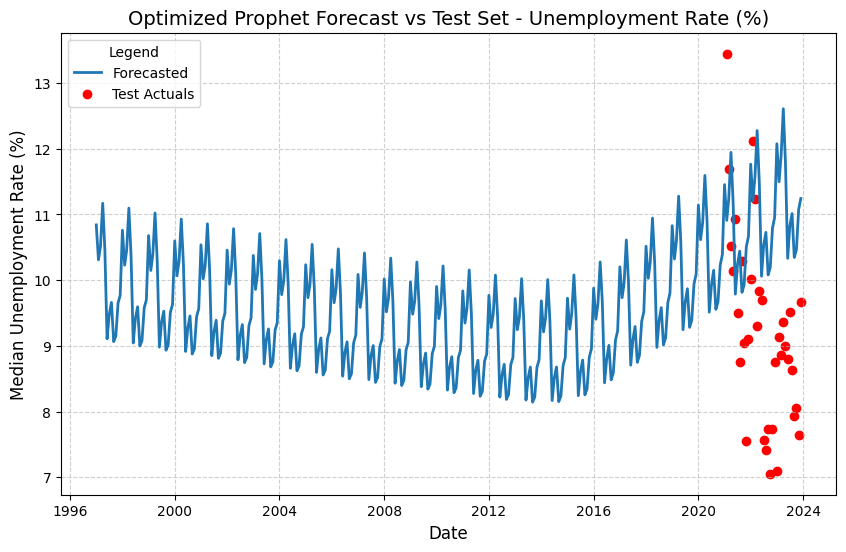

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted', linestyle='-', linewidth=2)
plt.scatter(evaluation.index, evaluation['y'], label='Test Actuals', color='red', marker='o')
plt.title("Optimized Prophet Forecast vs Test Set - Unemployment Rate (%)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Median Unemployment Rate (%)", fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

In [9]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add labels and title
fig.update_layout(
    title="Prophet Forecast - Unemployment Rate (%)",                 
    xaxis_title="Date",                       
    yaxis_title="Median Unemployment Rate (%)",        
    legend_title="Legend",                   
    font=dict(size=12),                       
)

# Show plot
fig.show()

In [10]:
# Generate plot
fig = plot_plotly(optimized_model, forecast)

# Add test data 
fig.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),  
        marker=dict(color='red')
    )
)

# Adjust x-axis range (2021-2023)
fig.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Unemployment Rate (%)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Unemployment Rate (%)',  # Add plot title
)

# Show plot
fig.show()

In [11]:
# Generate plot
fig = plot_components_plotly(optimized_model, forecast)

# Add title and labels
fig.update_layout(
    title="Prophet Forecast - Unemployment Rate (%)",     
    font=dict(size=12),                      
)       

# Show plot
fig.show()

# Optional: Download interactive plots (html)

In [12]:
# 1. Generate the first plot
fig1 = plot_plotly(optimized_model, forecast)
fig1.update_layout(
    title="Prophet Forecast - Unemployment Rate (%)",
    xaxis_title="Date",
    yaxis_title="Median Unemployment Rate (%)",
    legend_title="Legend",
    font=dict(size=12),
)

# Save the first plot as an HTML string
html1 = pio.to_html(fig1, full_html=False)

# 2. Generate the second plot
fig2 = plot_plotly(optimized_model, forecast)
fig2.add_trace(
    go.Scatter(
        x=test_data['ds'],  # x-axis (test data dates)
        y=test_data['y'],  # y-axis (actual values)
        mode='markers+lines',
        name='True Values (Test Data)',
        line=dict(color='red', dash='dot'),
        marker=dict(color='red')
    )
)
fig2.update_layout(
    xaxis=dict(
        range=['2021-01-01', '2023-12-31'],  # Set x-axis range
        title='Date',  # Add x-axis title
    ),
    yaxis=dict(
        title='Median Unemployment Rate (%)',  # Add y-axis title
    ),
    title='Prophet Forecast with Test Data (2021-2023) - Unemployment Rate (%)',
)

# Save the second plot as an HTML string
html2 = pio.to_html(fig2, full_html=False)

# 3. Generate the third plot
fig3 = plot_components_plotly(optimized_model, forecast)
fig3.update_layout(
    title="Prophet Forecast - Components (Unemployment Rate %)",
    font=dict(size=12),
)

# Save the third plot as an HTML string
html3 = pio.to_html(fig3, full_html=False)

# Combine all HTML strings into one HTML file
combined_html = f"""
<html>
<head>
    <title>Prophet Forecast Plots</title>
</head>
<body>
    <h1>Prophet Forecast - Interactive Plots</h1>
    <h2>1. Full Forecast</h2>
    {html1}
    <h2>2. Forecast with Test Data</h2>
    {html2}
    <h2>3. Forecast Components</h2>
    {html3}
</body>
</html>
"""

# Save the combined HTML to a file
with open("FB Prophet forecast plots (unemployment).html", "w") as f:
    f.write(combined_html)

# Print a message indicating where the file is saved
print("HTML file saved as 'FB Prophet forecast plots (unemployment).html'. Open this file to view the interactive plots.")


HTML file saved as 'FB Prophet forecast plots (unemployment).html'. Open this file to view the interactive plots.
